In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats



In [14]:

# --- Function to safely prefix zero (from our previous discussion) ---
def safe_prefix_zero(value):
    """
    Prepends '0.' to a string if it doesn't contain a decimal point and isn't '0' or starts with '0.'.
    Converts to float, handling errors.
    """
    s_value = str(value).strip()

    # Handle NaN, empty strings, or values already correctly formatted
    if not s_value or s_value.lower() == 'nan' or '.' in s_value or s_value.startswith('0'):
        try:
            return float(s_value)
        except ValueError:
            return np.nan # Return NaN if conversion fails
    else:
        # If no decimal and doesn't start with 0, add '0.' prefix
        try:
            return float(f"0.{s_value}")
        except ValueError:
            return np.nan # Return NaN if conversion fails

# --- Load and process your datasets ---

# 10k samples from qwen3
LM = pd.read_csv('./output_20250616_145900/20250616_145900_llm_floating_points.csv')
# Assume the column with numbers is 'floating-point'. Adjust if needed.
lm_col_name = 'floating-point'
LM[lm_col_name] = LM[lm_col_name].apply(safe_prefix_zero)
LM_values = LM[lm_col_name].dropna().astype('float64')

# 10k samples from pdfa using qwen3
PDFA_QNT = pd.read_csv('./output_pdfa_20250617_224321/20250617_224321_pdfa_floating_points.csv')
# Assume the column with numbers is 'floating-point'. Adjust if needed.
pdfa_qnt_col_name = 'floating-point'
PDFA_QNT_values = pd.to_numeric(PDFA_QNT[pdfa_qnt_col_name], errors='coerce').dropna().astype('float64')

# Check the number of samples after cleaning
print(f"Number of samples in LM (Qwen3) after correction: {len(LM_values)}")
print(f"Number of samples in PDFA_QNT (PDFA with Qwen3): {len(PDFA_QNT_values)}")

Number of samples in LM (Qwen3) after correction: 10000
Number of samples in PDFA_QNT (PDFA with Qwen3): 10000


In [15]:
print("\n--- Descriptive Statistics for LM (Qwen3) ---")
print(LM_values.describe())

print("\n--- Descriptive Statistics for PDFA_QNT (PDFA with Qwen3) ---")
print(PDFA_QNT_values.describe())


--- Descriptive Statistics for LM (Qwen3) ---
count   10000.000000
mean        0.463766
std         0.301473
min         0.000000
25%         0.197040
50%         0.375492
75%         0.746565
max         1.000000
Name: floating-point, dtype: float64

--- Descriptive Statistics for PDFA_QNT (PDFA with Qwen3) ---
count   10000.000000
mean        0.390311
std         0.327705
min         0.000011
25%         0.125658
50%         0.257794
75%         0.657535
max         1.000000
Name: floating-point, dtype: float64


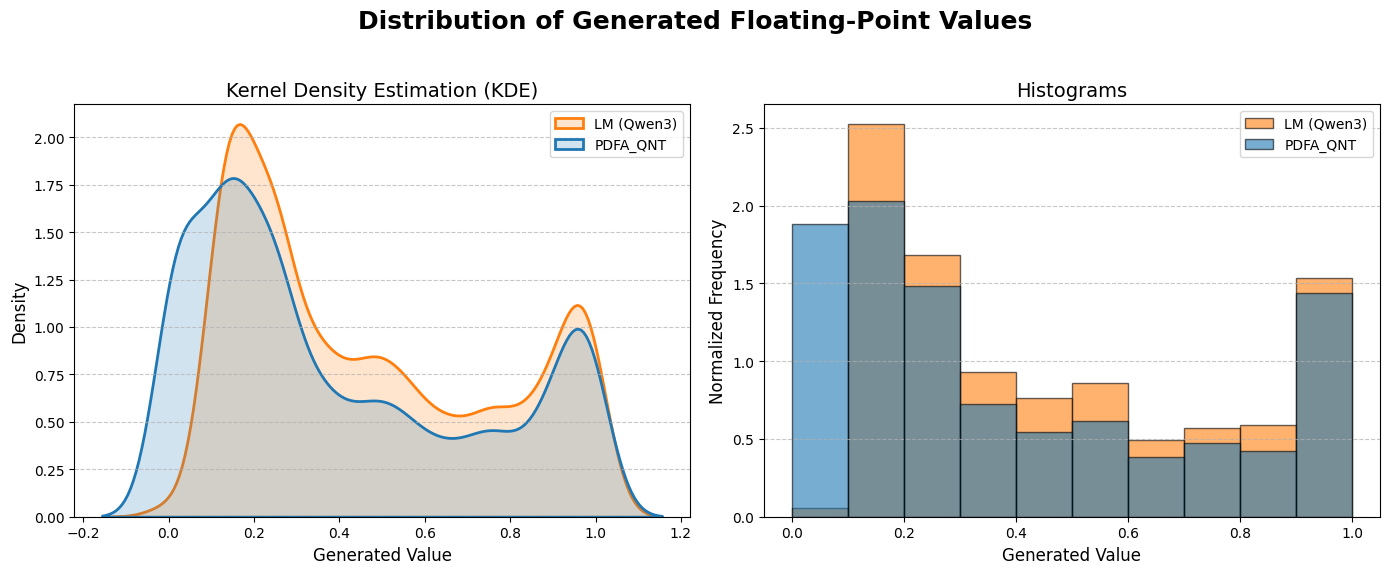

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution of Generated Floating-Point Values', fontsize=18, fontweight='bold')

# KDE Plot
sns.kdeplot(LM_values, fill=True, label='LM (Qwen3)', color='tab:orange', alpha=0.2, linewidth=2, ax=axes[0])
sns.kdeplot(PDFA_QNT_values, fill=True, label='PDFA_QNT', color='tab:blue', alpha=0.2, linewidth=2, ax=axes[0])
axes[0].set_xlabel('Generated Value', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Kernel Density Estimation (KDE)', fontsize=14)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram
bins = 10 # You can adjust the number of bins
axes[1].hist(LM_values, bins=bins, density=True, alpha=0.6, label='LM (Qwen3)', color='tab:orange', edgecolor='black')
axes[1].hist(PDFA_QNT_values, bins=bins, density=True, alpha=0.6, label='PDFA_QNT', color='tab:blue', edgecolor='black')
axes[1].set_xlabel('Generated Value', fontsize=12)
axes[1].set_ylabel('Normalized Frequency', fontsize=12)
axes[1].set_title('Histograms', fontsize=14)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for the suptitle
plt.show()

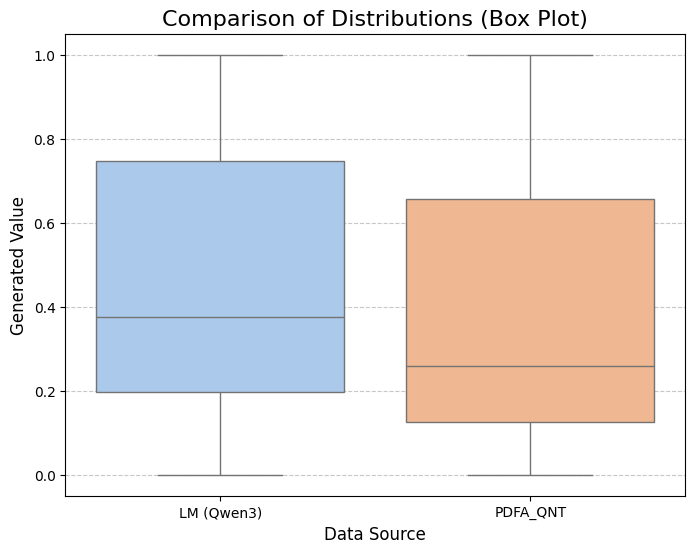

In [18]:
# Combine data into a single DataFrame for easier plotting with seaborn
data_for_boxplot = pd.DataFrame({
    'Source': ['LM (Qwen3)'] * len(LM_values) + ['PDFA_QNT'] * len(PDFA_QNT_values),
    'Value': pd.concat([LM_values, PDFA_QNT_values])
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Source', y='Value', data=data_for_boxplot, palette='pastel')
plt.title('Comparison of Distributions (Box Plot)', fontsize=16)
plt.xlabel('Data Source', fontsize=12)
plt.ylabel('Generated Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

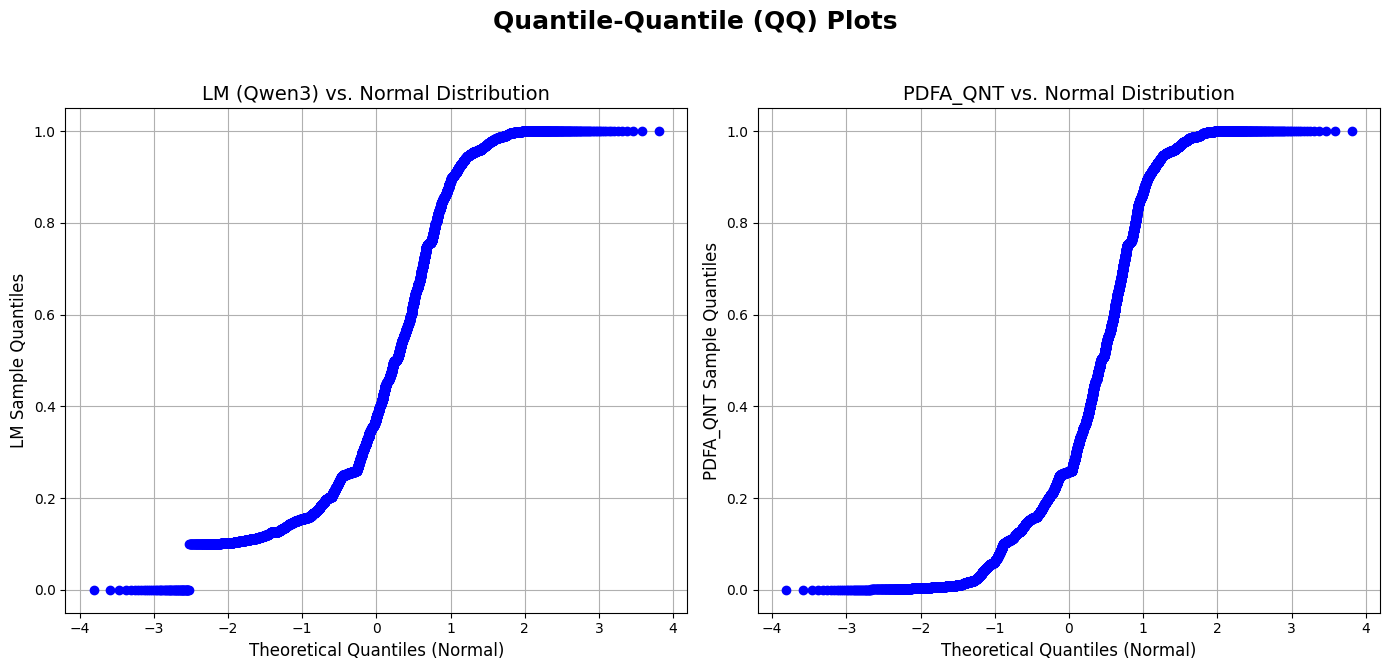

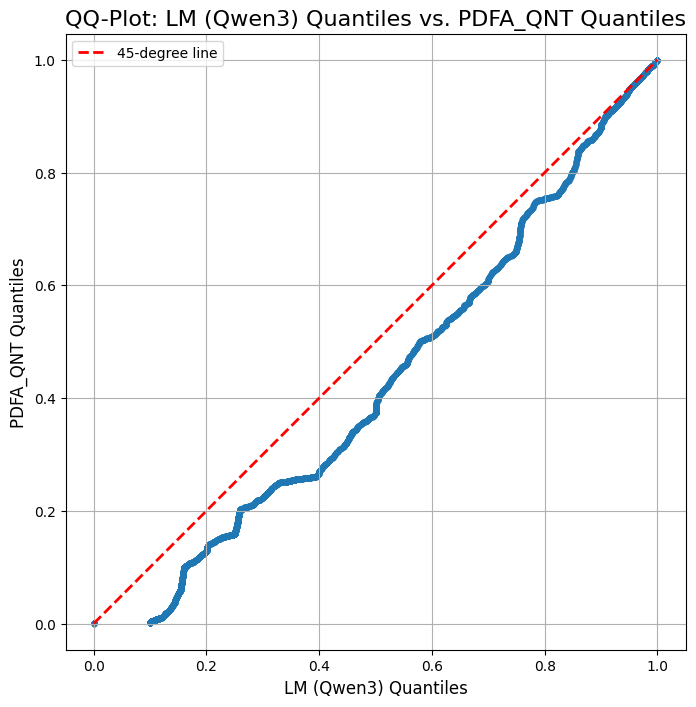

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Quantile-Quantile (QQ) Plots', fontsize=18, fontweight='bold')

# QQ-Plot for LM vs. Normal Distribution
stats.probplot(LM_values, dist=stats.norm, plot=axes[0], fit=False, rvalue=True)
axes[0].set_title('LM (Qwen3) vs. Normal Distribution', fontsize=14)
axes[0].set_xlabel('Theoretical Quantiles (Normal)', fontsize=12)
axes[0].set_ylabel('LM Sample Quantiles', fontsize=12)
axes[0].grid(True)

# QQ-Plot for PDFA_QNT vs. Normal Distribution
stats.probplot(PDFA_QNT_values, dist=stats.norm, plot=axes[1], fit=False, rvalue=True)
axes[1].set_title('PDFA_QNT vs. Normal Distribution', fontsize=14)
axes[1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=12)
axes[1].set_ylabel('PDFA_QNT Sample Quantiles', fontsize=12)
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- QQ-Plot to compare LM_values directly against PDFA_QNT_values ---
# For a direct comparison, it's best to compare quantiles of the same number of points
min_len = min(len(LM_values), len(PDFA_QNT_values))
sorted_lm = np.sort(LM_values)[:min_len]
sorted_pdfa = np.sort(PDFA_QNT_values)[:min_len]

plt.figure(figsize=(8, 8))
plt.scatter(sorted_lm, sorted_pdfa, alpha=0.6, s=10) # s=10 makes points smaller for 10k samples
plt.plot([min(sorted_lm), max(sorted_lm)], [min(sorted_lm), max(sorted_lm)], 'r--', lw=2, label='45-degree line')
plt.title('QQ-Plot: LM (Qwen3) Quantiles vs. PDFA_QNT Quantiles', fontsize=16)
plt.xlabel('LM (Qwen3) Quantiles', fontsize=12)
plt.ylabel('PDFA_QNT Quantiles', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure equal scaling on both axes
plt.show()

In [20]:
alpha = 0.05

# --- Test 1: Welch's t-test (Comparison of Means) ---
# Null Hypothesis (H0): The means of the two samples are equal.
# This test doesn't assume equal variances, making it more robust than a standard t-test.
t_stat, p_value_ttest = stats.ttest_ind(LM_values, PDFA_QNT_values, equal_var=False)

print("\n--- Welch's t-test (Comparison of Means) ---")
print(f"t-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_ttest:.4f}")
if p_value_ttest < alpha:
    print(f"Result: Reject H0. There is a statistically significant difference between the means (p < {alpha}).")
else:
    print(f"Result: Fail to reject H0. No significant difference between the means (p >= {alpha}).")


# --- Test 2: Mann-Whitney U test (Non-parametric Comparison of Distributions) ---
# Null Hypothesis (H0): The two samples come from the same population (i.e., their distributions are similar).
# This test is robust and doesn't assume normality or equal variances, making it suitable for many data types.
mw_stat, p_value_mw = stats.mannwhitneyu(LM_values, PDFA_QNT_values, alternative='two-sided')

print("\n--- Mann-Whitney U Test (Comparison of Distributions) ---")
print(f"U-statistic: {mw_stat:.4f}")
print(f"P-value: {p_value_mw:.4f}")
if p_value_mw < alpha:
    print(f"Result: Reject H0. The distributions are statistically significantly different (p < {alpha}).")
else:
    print(f"Result: Fail to reject H0. No significant evidence that the distributions are different (p >= {alpha}).")


# --- Test 3: Two-sample Kolmogorov-Smirnov Test (Comparison of Entire Distributions) ---
# Null Hypothesis (H0): The two samples are drawn from the same continuous distribution.
# This test is sensitive to differences in location, scale, and shape of the distributions.
ks2_stat, p_value_ks2 = stats.kstest(LM_values, PDFA_QNT_values)

print("\n--- Two-sample Kolmogorov-Smirnov (KS) Test ---")
print(f"KS-statistic: {ks2_stat:.4f}")
print(f"P-value: {p_value_ks2:.4f}")
if p_value_ks2 < alpha:
    print(f"Result: Reject H0. The two samples come from statistically significantly different distributions (p < {alpha}).")
else:
    print(f"Result: Fail to reject H0. The two samples could come from the same distribution (p >= {alpha}).")

print("\nNote on large sample sizes (10k): With very large datasets, even tiny, practically insignificant differences can result in a statistically significant p-value. Always interpret p-values in conjunction with visual inspections (histograms, KDEs, box plots) and descriptive statistics to gauge practical significance.")


--- Welch's t-test (Comparison of Means) ---
t-statistic: 16.4964
P-value: 0.0000
Result: Reject H0. There is a statistically significant difference between the means (p < 0.05).

--- Mann-Whitney U Test (Comparison of Distributions) ---
U-statistic: 58582706.0000
P-value: 0.0000
Result: Reject H0. The distributions are statistically significantly different (p < 0.05).

--- Two-sample Kolmogorov-Smirnov (KS) Test ---
KS-statistic: 0.1822
P-value: 0.0000
Result: Reject H0. The two samples come from statistically significantly different distributions (p < 0.05).

Note on large sample sizes (10k): With very large datasets, even tiny, practically insignificant differences can result in a statistically significant p-value. Always interpret p-values in conjunction with visual inspections (histograms, KDEs, box plots) and descriptive statistics to gauge practical significance.
